# Fetch Rewards Coding Exercise

In this script, I re-structured the `receipts.json`, `brands.json`, and `users.json` into a structured, tabular format. After turning the json files into tabular format, I identified some data quality issues worth investigating and clarifying with the business stakeholder. I also examined the question of "top 5 brands by receipts scanned for the most recent month" using MySQL and had the script written below for reference.


## Import Library

In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from datetime import datetime

## Read in Data

In this section, I read in and examined the three data files one by one. As I planned out in the ERD, additional tables will stem from the original receipts, users, and brands table.

### Receipts

Here, I first loaded the file into a tabular format, dealt with the nested data in the columns, and created an additional items table to store the items that each of the receipt numbers contains.

In [2]:
# read in receipts file
receipts = pd.read_json('receipts.json', lines=True)

In [3]:
# extract the oid values
receipts['_id'] = receipts['_id'].apply(lambda x: x['$oid'])

# create a function to extract the datetime values
# and change to the type of datetime
def cast_to_datetime(df, col):
  ans=[]
  for x in df[col].values:
    if type(x) == float:
      ans.append(np.nan)
    else:
      # assuming the datetime is in milliseconds
      ans.append(pd.to_datetime(datetime.fromtimestamp(x['$date'] // 1000)))
  df[col] = ans
  return df

# create a list of the columns that need to be transformed
date_cols = ['createDate', 'dateScanned', 'finishedDate',
             'modifyDate', 'pointsAwardedDate', 'purchaseDate']

# loop over the datetime columns
for col in date_cols:
  receipts = cast_to_datetime(receipts, col)

In [4]:
# receipts.to_csv('receipts.csv', index=False)

In [5]:
# generate the items table by examing the rewardsReceiptItemList in receipts data
item = pd.DataFrame()
item['oid'] = ''
id=[]

for i in range(len(receipts['rewardsReceiptItemList'])):
  x = receipts['rewardsReceiptItemList'].iloc[i]
  if type(x) != float:
    for y in x:
      item = pd.concat([item, pd.DataFrame.from_dict(y, orient='index').transpose()])
      item['oid'] = item['oid'].fillna(receipts.iloc[i]['_id'])

In [6]:
# item.to_csv('item.csv', index=False)

### Users

The users table is more straightforward and more structured - simply following the steps I did for the receipt data worked here.

In [7]:
# read in users data file
users = pd.read_json('users.json', lines=True)

# extract the id from the dictionary
users['_id'] = users['_id'].apply(lambda x: x['$oid'])

# create a list and loop over the columns that need to be datetime format
date_cols = ['createdDate', 'lastLogin']
for col in date_cols:
  users = cast_to_datetime(users, col)

In [8]:
# users.to_csv('users.csv', index=False)

### Brands

Here, in addition to examining the brands data, I also created an additional cpg table to store the results of the id and reference. Since the cpg data is a one-to-one relationship to the brands data, I merged it back to the original brands data, as planned out in my ERD.

In [9]:
# read in brands data file
brands = pd.read_json('brands.json', lines=True)

# extract the id from the dictionary format
brands['_id'] = brands['_id'].apply(lambda x: x['$oid'])

In [10]:
# loop over the cpg column to extract the oid and ref
cpg = pd.DataFrame()
id=[]
oid=[]
ref=[]

for i in range(len(brands['cpg'])):
  x = brands['cpg'].iloc[i]
  if type(x) != float:
      oid.append(brands['cpg'][i]['$id']['$oid'])
      ref.append(brands['cpg'][i]['$ref'])
      id.append(brands.iloc[i]['_id'])

cpg['id'] = id
cpg['oid'] = oid
cpg['ref'] = ref

In [11]:
# attach it back to the brands data since it's one-to-one relationship
brands = brands.merge(cpg, left_on='_id', right_on='id', how='left').drop('id', axis=1)

In [12]:
# brands.to_csv('brands.csv', index=False)

## Data quality check


In this section, I quickly examined null values for each of the tables and the numerical distribution.

As it turns out, for these data frames, there are many columns with a high rate of missing values, i.e., a lot of information is not available. This could be normal in some cases - For example, a user might not flag an item. Hence, the user-flagged-related columns remain of high NA values. However, it could be problematic in some cases. For example, when joining the items table to the brands table, the join key will be the barCode. Thus, with quite some missing values in the barCode column in the items table, the join of the two tables might lead to incomplete information.

I also checked the distribution of the numerical columns. Again, some make sense to have little rows being extreme values. However, it is worth confirming with the business stakeholders to make sure that these numbers (for example, earning 800+ points, purchasing 500+ items, or spending 4000+ dollars) are aligned with the business.

### Checking missing values

In [13]:
# create a function to get the null value percentage
def get_null_percentage(df):
  df_null_count = df.isnull().sum().sort_values(ascending=True)
  df_null_percent = round(df_null_count/len(df) * 100, 2)
  return df_null_percent

# create a function to generate a plot that shows the percentage of null values
def null_percent_plot(df, cutoff, plot_width, plot_height):
  df_null_percent = get_null_percentage(df)

  # plot the count of null values
  plt.figure(figsize=(plot_width, plot_height))
  df_null_percent.plot(kind='barh')
  plt.xlabel("Null Percentage")
  plt.ylabel("Data Columns")
  plt.title("Null percentage")
  plt.axvline(x=cutoff, color='darkgreen')
  plt.show()

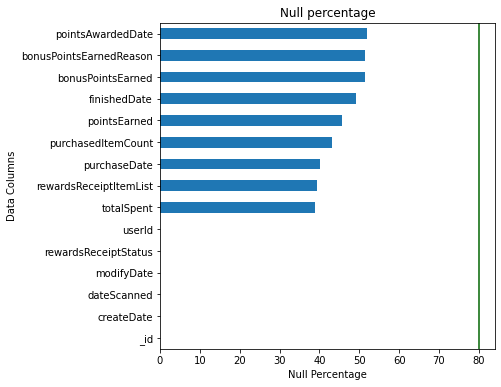

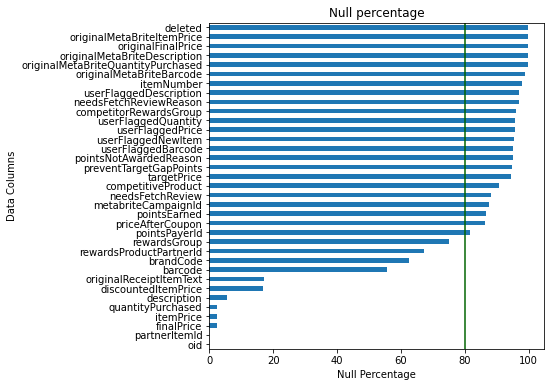

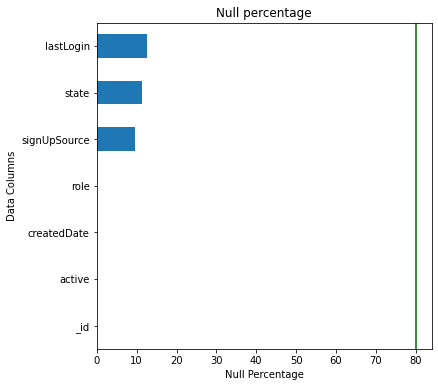

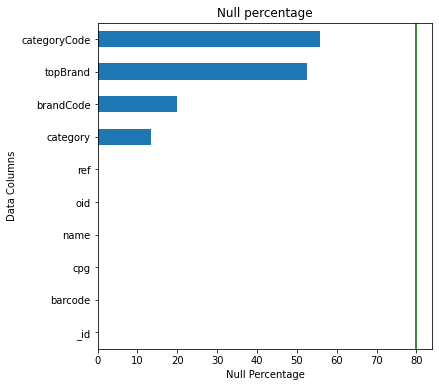

In [14]:
# use the function to examine null value percentages
for df in [receipts, item, users, brands]:
  null_percent_plot(df, 80, 6, 6)

### Checking numerical distribution

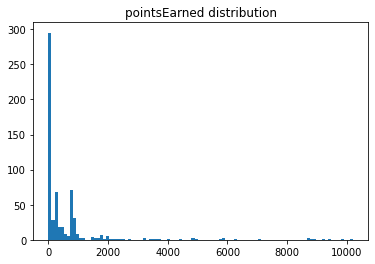

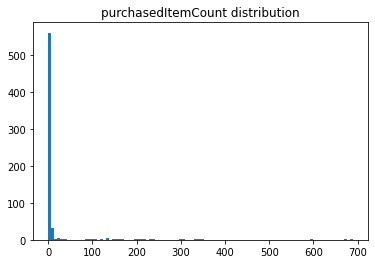

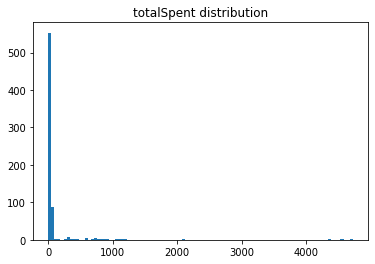

In [15]:
# create a function to plot the histogram
def plot_col_distribution(df, col, bins):
  df[col].hist(bins=bins)
  plt.title(col+" distribution")
  plt.gca().grid(False) 
  plt.show()

# create a function to show histograms for columns whose maximum value
# is greater than a user-defined sigma value
def plot_potential_outliers(df, num_sigma, bins):
  stats = df.describe().transpose()
  cols = stats[stats['max'] > stats['mean'] + stats['std'] * num_sigma].index.tolist()
  for col in cols:
    plot_col_distribution(df, col, bins=bins)

# use the function to see the columns whose maximum is greater than 3 std
plot_potential_outliers(receipts, 3, 100)

## Top 5 brands by receipts scanned for most recent month

In this section, I used MySQL syntax, as well as the database structure I designed, to answer the question of top 5 brands scanned for most recent month. 

In [16]:
# What are the top 5 brands by receipts scanned for most recent month?

"""
WITH recent_month AS (
  SELECT DATE_FORMAT(date_add(CURDATE(), interval -1 MONTH),'%Y-%m-01') AS past_month_first,
               DATE_FORMAT(CURDATE(),'%Y-%m-01') AS current_month_first
)
SELECT Items.brandCode,
             COUNT(DISTINCT(Items.receiptId)) as receipt_num
FROM   Items
JOIN     Receipts
ON       Receipts.receiptId = Items.receiptId
GROUP BY Items.brandCode
WHERE Receipts.purchaseDate >= (SELECT past_month_first FROM recent_month)
AND     Receipts.purchaseDate < (SELECT current_month_first FROM recent_month)
"""


"\nWITH recent_month AS (\n  SELECT DATE_FORMAT(date_add(CURDATE(), interval -1 MONTH),'%Y-%m-01') AS past_month_first,\n               DATE_FORMAT(CURDATE(),'%Y-%m-01') AS current_month_first\n)\nSELECT Items.brandCode,\n             COUNT(DISTINCT(Items.receiptId)) as receipt_num\nFROM   Items\nJOIN     Receipts\nON       Receipts.receiptId = Items.receiptId\nGROUP BY Items.brandCode\nWHERE Receipts.purchaseDate >= (SELECT past_month_first FROM recent_month)\nAND     Receipts.purchaseDate < (SELECT current_month_first FROM recent_month)\n"

## Communication with the business stakeholders

Lastly, I crafted an email to the stakeholders to explain my work and some of my concerns with the data in this section.

Hi all,

This is Jessica. I've been working on cleaning up the rewards data that I was given a few days ago, and I wanted to give you all an update on my progress and get my questions clarified.

There are some issues within the data that I would like to get some feedback on to make sure what I delivered would be of help:

1. Is there a complete list of the items that contain the item-specific information (such as its original price, original description, etc.) available? I would like this data to potentially reduce the amount of space needed to establish this database we need.
2. There are quite a few missing values in the dataset as I examined each of the columns. For example, a lot of items in the items list don't have an associated barCode. This might lead to problems when creating database relationships. Therefore, I wanted to clarify the relationship between itemNumber, brandCode, and barCode, to make sure I designed the database correctly.
3. There are also some extreme values in the dataset when I examined the distribution of the numerical columns. For example, a few transactions earned 800+ points, purchased 500+ items, or spent 4000+ dollars. I just wanted to make sure if this is a possible event, or is it incorrect information?
4. Lastly, as the number of rows adds up, the current approach I'm taking may take up more time and require more resources, and a traditional, relational database might not be the best solution. Is it possible to switch to other non-traditional data storage systems, such as NoSQL, since NoSQL is good at tackling json-formatted files?

Let me know what your thoughts are. I'd be happy to schedule a meeting to clarify these questions if you think a quick meeting would help.

Looking forward to hearing from you. 

Thanks!



Regards, 

Jessica
